# Image classification from file system

In the previous training lab we created a tensorflow dataset using 

```python
from_tensor_slices()
```

But now we are interested in another scenario. What if we have the classified images in different directories (this is, we a system folder for classA images, another for classB images, and so on).

Tensorflow allows us to create objects that will fetch this images in bunddles (batches) and load them to the model on demand. Hence, we won't have to load the whole set of images (potentially overloading the system memory) at once, but instead we may choose to gradually fetch them.

There's an extra added bonus feature for these types of objects : **preprocessing** is natively supported in by tensorflow, meaning that we can load and prepare the iamges at once. Also, it allows us to add a  **data-augmentation** process just as easily, providing us with a potential solution for overfitting problems (adressing bias).



## Downloading an appropriate dataset

I'm going to use a [kaggle](https://www.kaggle.com/) dataset here.

In order to do so in google colab, we have to follow the steps showcased [here](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a) or [here](https://colab.research.google.com/drive/1I7UN_1PljB3go4lugJrVEOLP86LnioS7?usp=sharing).

The code cells below aren't an exact replica of the guides, but my own take on it ...

### 1. Mounting drive directory

Let's mount the google drive directory - so we can access a personal key to use kaggle, and download the dataset we will be working with.

*Note* :  This will only work if you have a folder with the kaggle.json token pre-setup (see the guides linked above to do so)

In [1]:
import os
import pathlib
import zipfile

from google.colab import drive


The cell below will prompt a message asking for access permisions to the drive of an account (the google account running the colab instance)

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. The `kaggle.json` key

Now, to download the dataset we will have to add an enviromental variable linked to the drive directory that contains the kaggle.json key

In my case, I called that directory in drive /kaggle

In [ ]:
KAGGLE_KEY_PATH = "/content/gdrive/My Drive/kaggle"
os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_KEY_PATH

### 3. Locating and downloading the dataset

I want the intel-image-classification dataset - let's see if we can locate is by listing datasets in kaggle with similar keywords

In [ ]:
!kaggle datasets list -s intel-image-classification

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
puneet6060/intel-image-classification                           Intel Image Classification                        346MB  2019-01-30 09:22:58          79045       1321  0.75             
kkhandekar/image-dataset                                        Image_Dataset                                     171MB  2020-06-28 22:44:13            909         27  0.8125           
utkarshsaxenadn/intel-image-classifier-resblockcustom-model     Intel Image Classifier - ResBlock(Custom Model)   279KB  2022-10-02 02:48:22             10          8  1.0              
kutaykutlu/drowsiness-detection                                 Drowsi

In [ ]:
PATH_TO_DOWNLOAD = pathlib.Path('.').absolute() / "gdrive/My Drive/kaggle"

assert PATH_TO_DOWNLOAD.is_dir(), "\nUnable to locate the path provided or no-path provided"

print(str(PATH_TO_DOWNLOAD))

/content/gdrive/My Drive/kaggle


We can copy the path above to provide a path where the files will be downloaded (I prefer to download them in my drive, so I only have to do this once)

In [ ]:
'/'.join(str(PATH_TO_DOWNLOAD).split('/')[2:])

'gdrive/My Drive/kaggle'

Now, notice that since I have an space in the path (My Drive), I have to add a backslash so the path can be correctly read by the kaggle API download command.

Also, the path is given with respect to the current working directory - which is the content\/ directory for the google colab (*thus, the modification to the string done above*)

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification -p gdrive/My\ Drive/kaggle

 98% 341M/346M [00:01<00:00, 223MB/s]
100% 346M/346M [00:01<00:00, 196MB/s]


### 4. Extracting files

We have downloaded the zipfile - let's unzip it and delete the .zip

In [ ]:
os.listdir(PATH_TO_DOWNLOAD)

['kaggle.json', 'intel-image-classification.zip']

The downloaded file is `'intel-image-classification.zip'`

In [ ]:
# This cell may take a while to complete - 
# it's going to unzip the whole file sequentially ...

path_to_zip = PATH_TO_DOWNLOAD / "intel-image-classification.zip"

print('Begining the unzip process')
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(PATH_TO_DOWNLOAD)

print('Finished the unzipping')

Begining the unzip process
Finished the unzipping


Let's inspect the folders created

In [ ]:
print('Testing files')
print('*'*80,'\n')
print(f"Total # testing files : {len(os.listdir(PATH_TO_DOWNLOAD / 'seg_pred' / 'seg_pred'))}")

Testing files
******************************************************************************** 

Total # testing files : 7301


In [ ]:
count = 0
print('Validation (dev) files')
print('*'*80,'\n')
for subdir in os.listdir(PATH_TO_DOWNLOAD  / 'seg_test' / 'seg_test'):
  length = len(os.listdir(PATH_TO_DOWNLOAD  / 'seg_test' / 'seg_test' / subdir))
  print(subdir , ' # files : ' , length)
  count += length
print('_'*80)
print(f'Total # validation (dev) files : {count}')

Validation (dev) files
******************************************************************************** 

buildings  # files :  437
forest  # files :  474
glacier  # files :  553
mountain  # files :  525
sea  # files :  510
street  # files :  501
________________________________________________________________________________
Total # validation (dev) files : 3000


In [ ]:
count = 0
print('Training files')
print('*'*80,'\n')
for subdir in os.listdir(PATH_TO_DOWNLOAD  / 'seg_train' / 'seg_train'):
  length = len(os.listdir(PATH_TO_DOWNLOAD  / 'seg_train' / 'seg_train' / subdir))
  print(subdir , ' # files : ' , length)
  count += length
print('_'*80)
print(f'Total # train files : {count}')

Training files
******************************************************************************** 

buildings  # files :  2191
forest  # files :  2271
glacier  # files :  2404
mountain  # files :  2512
sea  # files :  2274
street  # files :  2382
________________________________________________________________________________
Total # train files : 14034


And delete the zipfile - let's free some memory space

In [ ]:
os.remove(path_to_zip)

## Tensorflow - Creating the dataset object

In [3]:
import pathlib
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [4]:
tf.device(tf.test.gpu_device_name())

Let's see some examples of the images we will be using

In [5]:
train_directory = pathlib.Path('.').absolute() / "gdrive/My Drive/kaggle/seg_train/seg_train"
print(str(train_directory))

/content/gdrive/My Drive/kaggle/seg_train/seg_train


In [6]:
# One image
image = plt.imread(train_directory /'buildings' /os.listdir(train_directory/'buildings')[200])

print(f"Image Shape : {image.shape}")
print(f"RGB Max values : {image.max(axis = (0,1))}")
print(f"RGB min values : {image.min(axis = (0,1))}")



Image Shape : (150, 150, 3)
RGB Max values : [245 255 255]
RGB min values : [0 0 0]


So, we have 150x150 rgb images

We can roll with this, or convert them to grey scale

Im my opinion, the RGB factor may play in out favour here ... as the coloration may give away the type of image we are looking at.

Nonetheless, we still have to rescale the values ...

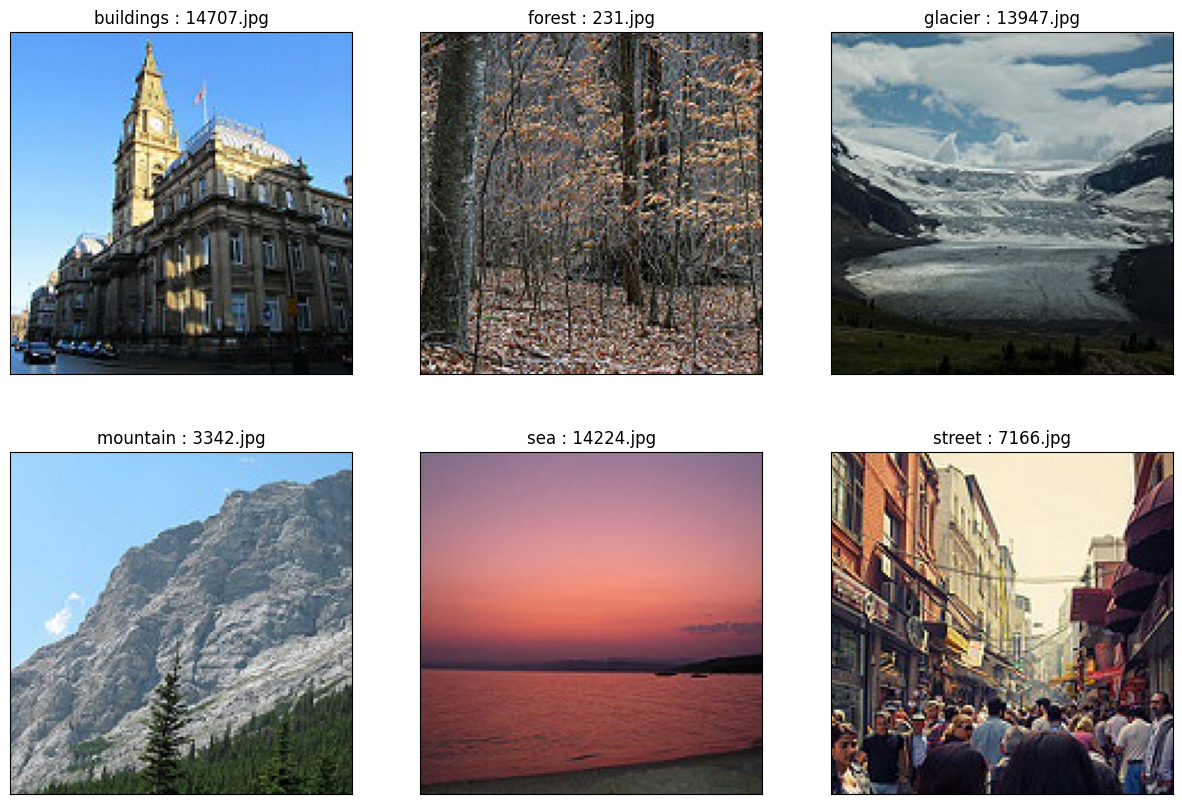

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10), squeeze = False)

training_folders = os.listdir(train_directory)

for i,ax in enumerate(axes.flatten()):
  ims_names = os.listdir(train_directory / training_folders[i])
  n_im = np.random.randint(0, len(ims_names))
  image = plt.imread(train_directory /training_folders[i] / ims_names[n_im])
  ax.set_title(f'{training_folders[i]} : {ims_names[n_im]}')
  ax.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.close()

fig

Awesome ... although quite a complex dataset.

Let's see if we are able of creating a convolutional network powerful enough to classify it ...

### Deprecated ImageDataGenerator

In this case, we could deal with this type process with the the image-data-generator object - that will take advantage of the directory structure to create the dataset for us.

But we instead may choose to use the newly recomended route to do this - that will allow us to prefetch images, as well as interleave loadings

In [ ]:
train_directory

PosixPath('/content/gdrive/My Drive/kaggle/seg_train/seg_train')

Old way of dealing with this
```python

tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.)

train_dataset = datagen.flow_from_directory(
    #directory = '.',
    directory = train_directory,
    target_size = (150,150),
    batch_size= 512,
    class_mode = "categorical" 
)
```

Now

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = train_directory,
    image_size = (150,150),
    batch_size = 16,
    label_mode = 'categorical'
)

Found 13843 files belonging to 6 classes.


In [9]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


### The model

This time, a bit more complex. let's have 3 levels of convolutional layers (conv+maxpool)

In [10]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', input_shape = (150,150,3)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64, (5,5), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation = 'relu'),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(6,activation = 'softmax'),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [11]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [12]:
model_h = model.fit(train_dataset, epochs = 5)

Epoch 1/5
 44/866 [>.............................] - ETA: 1:00:52 - loss: 14.5008 - accuracy: 0.2202

KeyboardInterrupt: ignored

In [ ]:
tf.keras.backend.clear_session()